In [1]:
import json
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

### Added Features:
- `readout_match`: Binary feature; 1 if the logical readout (L) matches the expected readout, otherwise 0.
- `index_flip`: Eight columns (index_flip_0 to index_flip_7), representing the number of bit flips for each index between the three rounds.
- `agreement`: Proportion of bits that agree across all three rounds for each row.
- `flip_errs`: Count of the number of errors (1s) in the last four bits (Z3, Z2, Z1, Z0) of each round, where these bits should always be zero.

In [2]:
# # File paths for the JSON files
# json_files = [
#     'data/json/qubit1Z_d3_a1_results.json',
#     'data/json/qubit1Z_d3_a2_results.json',
#     'data/json/qubit1Z_d3_b1_results.json'
# ]

# # Output file path for the concatenated results
# output_file = 'data/json/qubit1Z_d3_combined_results.json'

# # Function to load a JSON file
# def load_json_data(file_path):
#     try:
#         with open(file_path, 'r') as f:
#             return json.load(f)
#     except FileNotFoundError:
#         print(f"File {file_path} not found.")
#         return {}

# # Main script to concatenate JSON files
# def combine_data(json_files, output_file) : 
#     # Create an empty dictionary to store the concatenated data
#     combined_data = {}

#     # Loop over each JSON file and update the combined data
#     for file_path in json_files:
#         json_data = load_json_data(file_path)
        
#         # Merge the json_data with combined_data
#         for backend, data in json_data.items():
#             if backend in combined_data:
#                 combined_data[backend].update(data)  # Update existing backend data
#             else:
#                 combined_data[backend] = data  # Add new backend data
    
#     # Save the combined data to a new JSON file
#     with open(output_file, 'w') as f:
#         json.dump(combined_data, f, indent=4)

#     print(f"Data has been successfully concatenated into {output_file}.")

In [2]:
def json_to_expanded_df(json_file, d = 5, num_rounds = 3):
    with open(json_file, 'r') as f:
        data = json.load(f)

    def process_data(data):
        rows = []
        for backend, results in data.items():
            for key, count in results.items():
                split_data = key.split()  # Split based on space
                readout = int(split_data[0])  # L value (Z readout)
                bitstrings = split_data[1:]  # Remaining are the rounds

                # Flatten the bitstrings into individual bits
                expanded_bits = [int(bit) for bitstring in bitstrings for bit in bitstring]
                
                # Append backend, expanded bits, readout, and count
                rows.append([backend] + expanded_bits + [readout, count])

        return rows

    # Dynamically generate column names based on the bitstring length
    measure_bits = (d*d)-1  # 24 bits per round of d=5

    columns = ['backend']
    for r in range(num_rounds):
        for q in range(measure_bits):
            columns.append(f'bit_{q}_round_{r}')

    columns += ['z_readout', 'count']
    return pd.DataFrame(process_data(data), columns=columns)

def calculate_index_flip(row, measure_bits):
    """Calculate the number of flips for each bit between rounds."""
    flips = []
    
    # Iterate through the measure_bits bits 
    for i in range(measure_bits):
        # Check flips between round_0, round_1, and round_2
        bit_r0 = row[f'bit_{i}_round_0']
        bit_r1 = row[f'bit_{i}_round_1']
        bit_r2 = row[f'bit_{i}_round_2']
        
        # Count the flips between consecutive rounds
        flip_count = (bit_r0 != bit_r1) + (bit_r1 != bit_r2)
        flips.append(flip_count)
    
    return flips

def calculate_agreement(row, measure_bits):
    """Calculate the agreement between rounds for each bit."""
    agreement_count = 0

    # Iterate through the measure_bits bits and check if they agree across rounds
    for i in range(measure_bits):
        bit_r0 = row[f'bit_{i}_round_0']
        bit_r1 = row[f'bit_{i}_round_1']
        bit_r2 = row[f'bit_{i}_round_2']
        
        # Check if the bits are the same in all rounds
        if bit_r0 == bit_r1 == bit_r2:
            agreement_count += 1

    return agreement_count / measure_bits  # Proportion of agreement

def calculate_flip_errs(row, measure_bits):
    """
    Calculate the number of errors (1s) in the last measure_bits/2 bits of each round.

    Parameters:
    row: The row containing the bits data.
    measure_bits: The total number of measurement bits. 
                  The function will check the last measure_bits/2 bits for errors.
    """
    flip_errs = 0
    half_measure_bits = measure_bits // 2  # Calculate half of measure_bits

    # Iterate through the last half_measure_bits bits for each round
    for i in range(measure_bits - half_measure_bits, measure_bits):
        flip_errs += row[f'bit_{i}_round_0']
        flip_errs += row[f'bit_{i}_round_1']
        flip_errs += row[f'bit_{i}_round_2']

    return flip_errs

In [3]:
# def build_backend_classifier(df, expected_readout=1, d=5):
#     measure_bits = (d*d)-1
    
#     # readout_match (1 if z_readout matches expected_readout, else 0)
#     df['readout_match'] = (df['z_readout'] == expected_readout).astype(int)
    
#     # index_flip (how many times each bit flips between rounds)
#     index_flip_cols = [f'index_flip_{i}' for i in range(measure_bits)]
    
#     # index_flip_cols (flips between rounds)
#     df[index_flip_cols] = df.apply(lambda row: calculate_index_flip(row, measure_bits), axis=1, result_type='expand')

#     # agreement (proportion of bits that agree across rounds)
#     df['agreement'] = df.apply(lambda row: calculate_agreement(row, measure_bits), axis=1)

#     # flip_errs (count of errors in the last measure_bits/2 bits of each round)
#     df['flip_errs'] = df.apply(lambda row: calculate_flip_errs(row, measure_bits), axis=1)
    
#     # Select features for training (excluding backend and count)
#     X = df.drop(columns=['backend', 'count'])
#     y = df['backend']  # Target
    
#     # Split data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
#     # Create and train the RandomForestClassifier
#     clf = RandomForestClassifier(random_state=42)
#     clf.fit(X_train, y_train)
    
#     # Predictions and evaluation
#     y_pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
    
#     # Output accuracy and classification report
#     print(f"Accuracy: {accuracy * 100:.2f}%")
#     print("Classification Report:")
#     print(classification_report(y_test, y_pred))
    
#     return clf, df, y_test, y_pred

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def build_backend_classifier(df, mode, expected_readout=1, d=5):
    measure_bits = (d*d)-1
    
    # Calculate features based on stabilizer measurements
    df['readout_match'] = (df['z_readout'] == expected_readout).astype(int)
    index_flip_cols = [f'index_flip_{i}' for i in range(measure_bits)]
    df[index_flip_cols] = df.apply(lambda row: calculate_index_flip(row, measure_bits), axis=1, result_type='expand')
    df['agreement'] = df.apply(lambda row: calculate_agreement(row, measure_bits), axis=1)
    df['flip_errs'] = df.apply(lambda row: calculate_flip_errs(row, measure_bits), axis=1)
    
    # Select features for training (excluding backend and count)
    X = df.drop(columns=['backend', 'count'])
    y = df['backend']
    
    # Standardize features to improve model performance
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    
    if mode == 'rfc':
        # Initialize base models
        rf = RandomForestClassifier(random_state=42)
        gb = GradientBoostingClassifier(random_state=42)

        # Hyperparameter tuning with GridSearchCV for RandomForest
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_rf = grid_search.best_estimator_

        # Ensemble model using VotingClassifier
        ensemble_clf = VotingClassifier(estimators=[
            ('rf', best_rf),
            ('gb', gb)
        ], voting='soft')

        # Train the ensemble model
        ensemble_clf.fit(X_train, y_train)

        # Evaluate with cross-validation
        cv_scores = cross_val_score(ensemble_clf, X_train, y_train, cv=5, scoring='accuracy')
        print(f"Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}% ± {cv_scores.std() * 100:.2f}%")

        # Predictions and evaluation on test set
        y_pred = ensemble_clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Test Set Accuracy: {accuracy * 100:.2f}%")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion matrix for additional insights
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        return ensemble_clf, df, y_test, y_pred
    elif mode == 'mlp':
        # Standardize features (important for MLPs)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Define the MLP classifier
        mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, activation='relu', solver='adam', random_state=42)

        # Train the MLP
        mlp.fit(X_train, y_train)

        # Predictions and evaluation
        y_pred = mlp.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # Output accuracy and classification report
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)

        return mlp, scaler, y_test, y_pred

In [28]:
json_file = 'data/drift_results/combined_results.json'
df = json_to_expanded_df(json_file, d=5)
df

,backend,bit_0_round_0,bit_1_round_0,bit_2_round_0,bit_3_round_0,bit_4_round_0,bit_5_round_0,bit_6_round_0,bit_7_round_0,bit_8_round_0,...,bit_16_round_2,bit_17_round_2,bit_18_round_2,bit_19_round_2,bit_20_round_2,bit_21_round_2,bit_22_round_2,bit_23_round_2,z_readout,count
0,ibm_sherbrooke_A_20241031,0,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
1,ibm_sherbrooke_A_20241031,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1
2,ibm_sherbrooke_A_20241031,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,1
3,ibm_sherbrooke_A_20241031,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,ibm_sherbrooke_A_20241031,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,ibm_brisbane_B_20241107,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,1
99996,ibm_brisbane_B_20241107,1,0,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,1
99997,ibm_brisbane_B_20241107,1,1,1,0,0,0,1,0,1,...,1,1,0,0,0,0,0,0,0,1
99998,ibm_brisbane_B_20241107,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1


In [40]:
def get_backend_results(df, backend, suffix, mode, d=5):
    target_backend = f'{backend}{suffix}'
    print(f"Classifying for backend: {target_backend}")
    clf, df, y_test, y_pred = build_backend_classifier(df, mode, expected_readout=1, d=d)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\tAccuracy: {accuracy * 100:.2f}%")
    
    return clf, df, y_test, y_pred

def plot_confusion_matrices(results, filename, backends = []):
    num_matrices = len(results)
    cols = 2  # Display 2 matrices per row for readability
    rows = (num_matrices + cols - 1) // cols
    plt.figure(figsize=(10 * cols, 8 * rows))  # Larger figure size for clarity
    
    for i, result in enumerate(results):
        plt.subplot(rows, cols, i + 1)
        cm = confusion_matrix(result['y_test'], result['y_pred'])
        
        # Convert counts to proportions
        cm_proportions = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Display the confusion matrix with proportions
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_proportions)
        disp.plot(cmap='magma', ax=plt.gca(), colorbar=True, values_format='.2f')
        
        # Adjust title and labels for readability
        plt.title(result['backend'], fontsize=18)
        plt.xlabel('Predicted label', fontsize=16)
        plt.ylabel('True label', fontsize=16)
        
        # Set custom tick labels with {backend}{suffix}
        backend_suffix_labels = [backends[i] if backends else str(i) for i in range(len(backends) if backends else cm.shape[0])]
        plt.gca().set_xticks(np.arange(cm.shape[0]))
        plt.gca().set_xticklabels(backend_suffix_labels, fontsize=10, rotation=90)
        plt.gca().set_yticks(np.arange(cm.shape[0]))
        plt.gca().set_yticklabels(backend_suffix_labels, fontsize=10)
    
    plt.tight_layout(pad=0.05)  # Increase padding
    plt.savefig(filename, dpi=300)
    plt.show()
    
def get_results_all_backends(mode, backends=['ibm_brisbane', 'ibm_sherbrooke', 'ibm_kyiv'], dates=['20241106', '20241101', '20241031']):
    results = []

    json_file = 'data/drift_results/combined_results.json'
    df = json_to_expanded_df(json_file, d=5)

    # Loop through backends and create suffix combinations
    suffixes = [f"_{suffix}_{date}" for suffix in ['A', 'B', 'C'] for date in dates]

    clf, df, y_test, y_pred = build_backend_classifier(df, mode, expected_readout=1, d=d)
    accuracy = accuracy_score(y_test, y_pred)
    results = [{
                'clf': clf,
                'y_test': y_test,
                'y_pred': y_pred
            }]
    return results

In [35]:
results = get_results_all_backends(mode='mlp')

Classifying for backend: ibm_brisbane_A_20241106
Accuracy: 51.54%
Classification Report:
                           precision    recall  f1-score   support

  ibm_brisbane_A_20241031       0.56      0.54      0.55      1473
  ibm_brisbane_A_20241106       0.51      0.58      0.54      1502
  ibm_brisbane_B_20241031       0.60      0.48      0.53      1517
  ibm_brisbane_B_20241106       0.45      0.42      0.43      1455
  ibm_brisbane_C_20241031       0.46      0.53      0.49      1487
  ibm_brisbane_C_20241106       0.51      0.56      0.53      1481
      ibm_kyiv_A_20241106       0.59      0.63      0.61      1508
      ibm_kyiv_B_20241106       0.60      0.65      0.62      1500
      ibm_kyiv_C_20241106       0.61      0.60      0.61      1527
ibm_sherbrooke_A_20241031       0.52      0.53      0.52      1486
ibm_sherbrooke_A_20241101       0.52      0.49      0.50      1514
ibm_sherbrooke_A_20241106       0.54      0.56      0.55      1564
ibm_sherbrooke_B_20241031       0.49   

In [36]:
backends = ["ibm_brisbane_A_20241031", "ibm_brisbane_A_20241106",
            "ibm_brisbane_B_20241031", "ibm_brisbane_B_20241106",
            "ibm_brisbane_C_20241031", "ibm_brisbane_C_20241106",
            "ibm_kyiv_A_20241106", "ibm_kyiv_B_20241106", "ibm_kyiv_C_20241106", 
            "ibm_sherbrooke_A_20241031", "ibm_sherbrooke_A_20241101", "ibm_sherbrooke_A_20241106",
            "ibm_sherbrooke_B_20241031", "ibm_sherbrooke_B_20241101", "ibm_sherbrooke_B_20241106",
            "ibm_sherbrooke_C_20241031", "ibm_sherbrooke_C_20241101", "ibm_sherbrooke_C_20241106"]

In [38]:
results

[{'backend': 'ibm_brisbane_A_20241106',
  'clf': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
  'y_test': 89610    ibm_sherbrooke_B_20241106
  12456    ibm_sherbrooke_C_20241031
  53403    ibm_sherbrooke_C_20241106
  62905          ibm_kyiv_C_20241106
  66339    ibm_sherbrooke_A_20241101
                     ...            
  22401      ibm_brisbane_B_20241031
  17739      ibm_brisbane_A_20241031
  20969      ibm_brisbane_B_20241031
  23602      ibm_brisbane_B_20241031
  17462      ibm_brisbane_A_20241031
  Name: backend, Length: 27000, dtype: object,
  'y_pred': array(['ibm_sherbrooke_B_20241106', 'ibm_sherbrooke_C_20241031',
         'ibm_sherbrooke_B_20241106', ..., 'ibm_kyiv_A_20241106',
         'ibm_brisbane_B_20241031', 'ibm_brisbane_B_20241106'], dtype='<U25')}]

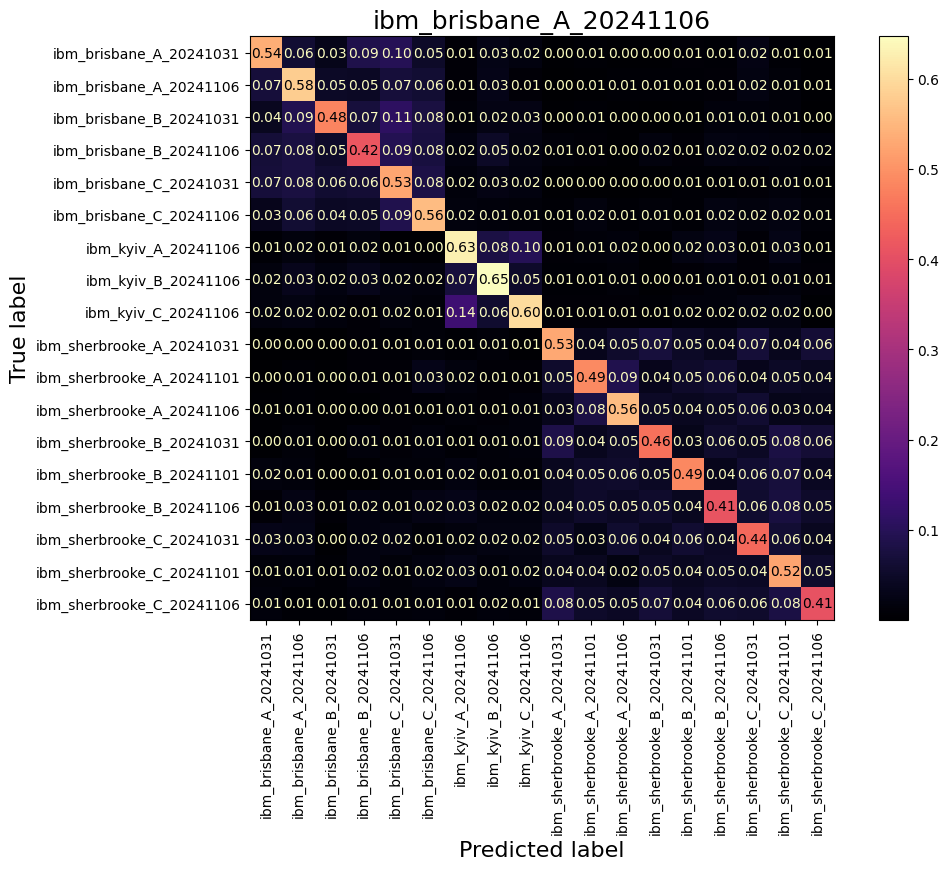

In [37]:
plot_confusion_matrices(results, 'drift_matrix_mlp.png', backends)

In [12]:
import numpy as np

In [ ]:
def get_results_all_backends(mode, backends=['ibm_brisbane', 'ibm_sherbrooke', 'ibm_kyiv'], dates=['20241106', '20241101', '20241031']):
    results = []

    # Generate suffix combinations for all specified backends, regions, and dates
    suffixes = [f"{backend}_{region}_{date}" 
                for backend in backends
                for region in ['A', 'B', 'C'] 
                for date in dates]

    # Load your dataset
    json_file = 'data/drift_results/combined_results.json'
    df = json_to_expanded_df(json_file, d=5)

    # Run the classifier once, treating it as a multi-class classifier
    clf, df, y_test, y_pred = build_backend_classifier(df, mode, expected_readout=1, d=5)

    # Compute accuracy and store the results
    accuracy = accuracy_score(y_test, y_pred)
    results.append({
        'clf': clf,
        'y_test': y_test,
        'y_pred': y_pred,
        'accuracy': accuracy
    })

    # Plot and save the confusion matrix
    plot_confusion_matrices(results, 'drift_matrix.png')

    return results